## Question 1

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Import data
df = pd.read_csv('C:/Users/theoh/Dropbox (University of Oregon)/Oregon/GEOG 490/geospatial-data-science/labs/lab5/data/california_house_prices.csv')

# Read dataset
coast = gpd.read_file('C:/Users/theoh/Dropbox (University of Oregon)/Oregon/GEOG 490/geospatial-data-science/labs/lab5/data/california_coastline.shp')

In [3]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
gdf = gdf.set_crs(4326, allow_override=True)

# Reproject everything to UTM 10N (EPSG:32610)
gdf_utm = gdf.to_crs('EPSG:32610')
coast_utm = coast.to_crs('EPSG:32610')

In [4]:
# Compute distance to coast
distance_to_coast = []
for i in range(gdf_utm.shape[0]):
    distance_to_coast.append(coast_utm.distance(gdf_utm['geometry'].iloc[i]).min())
    
# Add to DataFrame
gdf_utm['distance_to_coast'] = distance_to_coast

* **How many houses are in this dataset?**

In [5]:
total_houses = gdf_utm['households'].sum()
print(f'{total_houses} houses in the GeoDataFrame')

7798603 houses in the GeoDataFrame


* **How many features are there for predicting house price?**

In [6]:
gdf_utm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,geometry,distance_to_coast
0,-122.46,37.74,51,1905,291,707,284,6.2561,431000,POINT (547577.632 4177105.352),4250.279734
1,-122.00,36.93,51,1616,374,608,302,3.1932,400000,POINT (589058.834 4087574.079),3240.881530
2,-122.47,37.75,51,2413,431,1095,437,4.0089,357000,POINT (546690.276 4178209.800),3471.400270
3,-118.30,34.19,51,1502,243,586,231,4.3750,332400,POINT (933246.309 3793222.021),27012.552131
4,-118.32,33.83,51,2399,516,1160,514,3.8456,318900,POINT (933231.253 3753170.651),6558.554745


In [7]:
print(f'{len(gdf_utm.columns)} features for predicting house price')

11 features for predicting house price


* **Are there any null values in this dataset?**

In [8]:
# Check if there are any null values in the dataframe
gdf_utm.isnull().values.any()

False

False means that there are no null values in the dataframe

* **Which three variables are best correlated with house price (include correlation coefficients**

In [9]:
# Compute correlation matrix
corr_matrix = gdf_utm.corr()

In [10]:
# Display top 3 features that correlate with median house value
top3 = corr_matrix["median_house_value"]
top3 = top3.abs().sort_values(ascending=False)
top3[1:4]

median_income        0.668566
distance_to_coast    0.505078
latitude             0.173908
Name: median_house_value, dtype: float64

* **Which three variables are least correlated with house price (include correlation coefficients)?**

In [11]:
# Display 3 least correlated features with median house value
least3 = corr_matrix["median_house_value"]
least3 = least3.abs().sort_values(ascending=True)
least3[0:3]

housing_median_age    0.014355
longitude             0.020092
population            0.020930
Name: median_house_value, dtype: float64

***

## Question 2

In [12]:
# Import modules
from cenpy import products
from geopandas import gpd
from sklearn.metrics import mean_squared_error

In [13]:
# Download median income (B19013_001E), education (B15012_001E), and total population (B01003_001E)
# data at tract level for Seattle
seattle = products.ACS().from_msa('Seattle, WA', level='tract',
                                        variables=['B19013_001E','B15012_001E', 'B01003_001E'])

C:\Users\theoh\anaconda3\envs\lab5\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\theoh\anaconda3\envs\lab5\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\theoh\anaconda3\envs\lab5\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.gith

In [14]:
# Rename columns
seattle = seattle.rename(columns={"B15012_001E": "education", "B19013_001E": "median_income", "B01003_001E": "population"})

# Reporject seattle data layer
seattle = seattle.to_crs('EPSG:32610')

# Calculate polygon areas (km^2)
seattle["area"] = seattle['geometry'].area/ 10**6

# Calculate population density (per km^2)
seattle["pop_dens"] = seattle['population']/seattle['area']

In [15]:
seattle.head()

,GEOID,geometry,population,education,median_income,NAME,state,county,tract,area,pop_dens
0,53053072503,"POLYGON ((522457.021 5246473.902, 522478.408 5...",4412.0,1226.0,87939.0,"Census Tract 725.03, Pierce County, Washington",53,053,072503,22.515766,195.951580
1,53053072309,"POLYGON ((532131.496 5230757.721, 532885.423 5...",6352.0,1945.0,65179.0,"Census Tract 723.09, Pierce County, Washington",53,053,072309,5.504272,1154.012813
2,53053072310,"POLYGON ((533535.594 5229972.689, 533592.330 5...",3729.0,865.0,57266.0,"Census Tract 723.10, Pierce County, Washington",53,053,072310,2.097373,1777.938644
3,53053071803,"POLYGON ((535792.770 5225158.820, 535793.453 5...",5560.0,851.0,42943.0,"Census Tract 718.03, Pierce County, Washington",53,053,071803,4.605362,1207.288477
4,53053061200,"POLYGON ((539069.093 5233077.575, 539071.505 5...",5592.0,1359.0,67898.0,"Census Tract 612, Pierce County, Washington",53,053,061200,1.889067,2960.191416


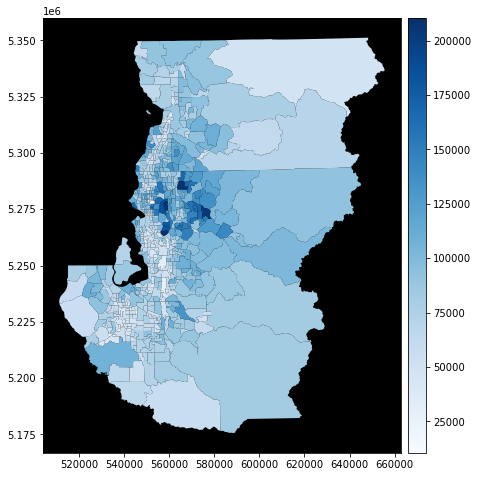

In [16]:
# Display median income levels for Seattle

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot map
f, ax = plt.subplots(1, 1, figsize=(8,8))

# These two lines make the colorbar the same size as the axes.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

seattle.plot('median_income', ax=ax, cmap='Blues', legend=True, cax=cax)

# Change background color to black
ax.set_facecolor('k')

# Disable scientific notation for legend values
plt.ticklabel_format(style='plain')

In [17]:
# Import housing data
df_sea = pd.read_csv('C:/Users/theoh/Dropbox (University of Oregon)/Oregon/GEOG 490/geospatial-data-science/labs/lab5/data/seattle_house_prices.csv')

In [18]:
# Convert DataFrame to GeoDataFrame
gdf_sea = gpd.GeoDataFrame(df_sea, geometry=gpd.points_from_xy(df_sea['long'], df_sea['lat']))
gdf_sea = gdf_sea.set_crs(4326, allow_override=True)

# Reproject everything to UTM 10N (EPSG:32610)
gdf_sea_utm = gdf_sea.to_crs('EPSG:32610')

In [19]:
gdf_sea_utm.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,yr_built,lat,long,geometry
0,538000,3,2.25,2570,7242,1951,47.7210,-122.319,POINT (551072.719 5285515.861)
1,180000,2,1.00,770,10000,1933,47.7379,-122.233,POINT (557503.790 5287454.424)
2,604000,4,3.00,1960,5000,1965,47.5208,-122.393,POINT (545697.119 5263219.897)
3,510000,3,2.00,1680,8080,1987,47.6168,-122.045,POINT (571764.358 5274152.358)
4,1230000,4,4.50,5420,101930,2001,47.6561,-122.005,POINT (574714.119 5278557.838)


In [20]:
# Join polygon attributes to each house
points = gdf_sea_utm
polys = seattle
seattle_houses = gpd.sjoin(points, polys, op='within')

C:\Users\theoh\anaconda3\envs\lab5\lib\site-packages\IPython\core\interactiveshell.py:3191: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [21]:
# Import water bodies
water = gpd.read_file('C:/Users/theoh/Dropbox (University of Oregon)/Oregon/GEOG 490/geospatial-data-science/labs/lab5/data/washington_coastline.shp')

# Convert to 32610
water_utm = water.to_crs('EPSG:32610')

In [22]:
# Compute distance to water
distance_to_water = []
for i in range(seattle_houses.shape[0]):
    distance_to_water.append(water_utm.distance(seattle_houses['geometry'].iloc[i]).min())
    
# Add to DataFrame
seattle_houses['distance_to_water'] = distance_to_water

In [23]:
# Compute correlation matrix
sea_corr_matrix = seattle_houses.corr()

In [24]:
# Display correlation matrix
top = sea_corr_matrix["price"]
top = top.sort_values(ascending=False)
top

price                1.000000
sqft_living          0.702296
bathrooms            0.524395
median_income        0.504125
education            0.376540
bedrooms             0.315804
lat                  0.308082
sqft_lot             0.090125
yr_built             0.052453
distance_to_water    0.027830
long                 0.020092
population           0.012869
index_right         -0.004545
area                -0.026486
pop_dens            -0.051618
Name: price, dtype: float64

In [25]:
# Define feature list
feature_list =  ['bedrooms', 'bathrooms', 'sqft_living', 
                 'sqft_lot', 'yr_built', 'lat', 'long', 'median_income', 'education', 'pop_dens', 'distance_to_water']

# Define features and labels 
X = seattle_houses[feature_list]
y = seattle_houses['price']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [26]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

**Random Forest**

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 100)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [28]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

146265.32037458973

(0.0, 1000000.0)

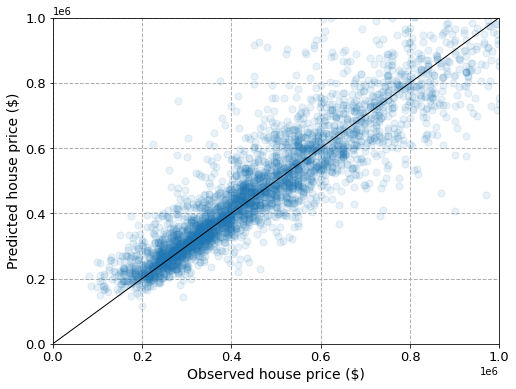

In [29]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,1000000], [0, 1000000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted house price ($)', fontsize=14)
ax.set_xlabel('Observed house price ($)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,1000000)
ax.set_xlim(0,1000000)